# Coffee Shop in Baku

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Sources](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

<h2>Introduction</h2> <a name="introduction"></a>

A group of friends have decided to pull together some funding and open up a new coffee shop. But when it came down to deciding the most suitable location for the new place, opinions of the funders have split. Some wanted it to be located in the most busy suburb where there **are already a lot of similar places**, some wanted the new place to be located where, on the contrary, **the fewest amount of potential competitors exist**. 

*While it is impossible to predict with any amount of certainty whether or not a new coffee shop will be successful, the aim of this project is to illuminate the potential suburbs to have the new coffee shop in and to provide the insights to the decision-makers regardles of the strategy the employ.*

<h2>Data Sources</h2> <a name="data"></a>

Data to be used in this project will come from two separate sources:

1) <s>http://www.mapcrow.info/ - this web-sites provides an easy way to extract suburbs names from complicated datasource of OpenStreetMap. By parsing this site we will be able to extract names and geographical coordinates of all city-wide suburbs without having to go through large database of objects in OSM project</s>

1) Upon further investigation it became apparent that MapCrow project lacks some of the more prominent raions in Baku, which would make this analysis incomplete. Instead, a **Wikipedia page on administrative division of Baku** will be used. Unfortunatelly, only version of Wikipedia with relevant information is in Azerbaijani, which is why these raions may look foreign to you.

2) **Foursquare** - this is a required step. Foursquare data will be used to determine available venues and their categories in each of the raions.

_Important note: raion, suburb and neighborhood are used somewhat interchangeably. There are, however, significant differences between these terms. For the purpose of this project, ideally, smallest quantifiable item should be used. But there is no source on neighborhoods in Baku that I can quote and\or parse. Same goes for suburbs - I know names and approximate division lines of most of them, but I cannot provide a single reference. Unfortunatelly, documentation on such things in smaller cities are non-existant.  Which is why I have decided to go with raions._

`A raion (also rayon) is a type of administrative unit of several post-Soviet states (such as part of an oblast). The term is from the French "rayon" (meaning "honeycomb, department"),[1] which is both a type of a subnational entity and a division of a city, and is commonly translated in English as "district".[2]
A raion is a standardized administrative entity across most of the former Soviet Union and is usually a subdivision two steps below the national level. However, in smaller USSR republics, it could be the primary level of administrative division. After the fall of the Soviet Union, some of the republics kept the raion (e.g. Azerbaijan) while others dropped it (e.g. Armenia).` (c) <a href =https://en.wikipedia.org/wiki/Raion>Wikipedia</a>

In [290]:
# Importing modules to work with

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

#To assign geographical coordinates
import geocoder
import geopy

#This is for the visualizations
import folium
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline 

## Extracting the raions

In [115]:
#Converting Wikipedia page to an html code
html = 'https://az.wikipedia.org/wiki/Bak%C4%B1_rayonlar%C4%B1n%C4%B1n_siyah%C4%B1s%C4%B1'
r = requests.get(html).text
soup = BeautifulSoup(r, 'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="az">
 <head>
  <meta charset="utf-8"/>
  <title>
   Bakı rayonlarının siyahısı - Vikipediya
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":[",\t.",".\t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","yanvar","fevral","mart","aprel","may","iyun","iyul","avqust","sentyabr","oktyabr","noyabr","dekabr"],"wgMonthNamesShort":["","yanvar","fevral","mart","aprel","may","iyun","iyul","avqust","sentyabr","oktyabr","noyabr","dekabr"],"wgRequestId":"XlEHLgpAMEwAADOAn6cAAAAY","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Bakı_rayonlarının_siyahısı","wgTitle":"Bakı rayonlarının siyahısı","wgCurRevisionId":4853210,"wgRevisionId":4853210,"wgArticleId":600585,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Bak

In [116]:
#Now we need to select the table of interest within the HTML

table = soup.find('table',{'class':'wikitable sortable'})
print(table)

<table class="wikitable sortable">
<tbody><tr>
<th>Rayon
</th>
<th>Əhali
</th>
<th>Sahə (km²)
</th></tr>
<tr>
<td><a href="/wiki/Qarada%C4%9F_rayonu" title="Qaradağ rayonu">Qaradağ</a><sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup></td>
<td>114 671</td>
<td>1.080
</td></tr>
<tr>
<td><a href="/wiki/Bin%C9%99q%C9%99di_rayonu" title="Binəqədi rayonu">Binəqədi</a><sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup></td>
<td>249325</td>
<td>149,69
</td></tr>
<tr>
<td><a href="/wiki/Nizami_rayonu_(Bak%C4%B1)" title="Nizami rayonu (Bakı)">Nizami</a><sup class="reference" id="cite_ref-3"><a href="#cite_note-3">[3]</a></sup></td>
<td>247.000</td>
<td>19,6
</td></tr>
<tr>
<td><a href="/wiki/N%C9%99rimanov_rayonu" title="Nərimanov rayonu">Nərimanov</a><sup class="reference" id="cite_ref-4"><a href="#cite_note-4">[4]</a></sup></td>
<td>156 700</td>
<td>24,5 
</td></tr>
<tr>
<td><a href="/wiki/N%C9%99simi_rayonu" title="Nəsimi rayonu">Nəsimi</a><su

In [288]:
#Initializng empty list to be filled with data from column of interest
hood = []

#Looping through each row within table having all 3 values (to exclude headers) and populating our list
for row in table.findAll("tr"):
    cells = row.findAll('td')
    if len(cells) == 3: 
    #Only extract text, because some of the values in the table are also links with tags
        hood.append(cells[0].find(text=True))

In [289]:
#Let's check that all raions are in place
hood

['Qaradağ',
 'Binəqədi',
 'Nizami',
 'Nərimanov',
 'Nəsimi',
 'Pirallahı',
 'Sabunçu',
 'Səbail',
 'Suraxanı',
 'Xətai',
 'Xəzər',
 'Yasamal']

In [121]:
#Now we need coordinates of these raions for further analysis

lat = []
lon = []

for h in hood:
    address = '{}, Baku, Azerbaijan'.format(h)
    geolocator = geopy.Nominatim(user_agent="qaqulik")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lat.append(latitude)
    lon.append(longitude)
    print('The geograpical coordinate of {}, Baku are {}, {}.'.format(h, latitude, longitude))

The geograpical coordinate of Qaradağ, Baku are 40.2424369, 49.5902597.
The geograpical coordinate of Binəqədi, Baku are 40.4679226, 49.828023.
The geograpical coordinate of Nizami, Baku are 40.3793366, 49.8302202.
The geograpical coordinate of Nərimanov, Baku are 40.4029647, 49.8710407.
The geograpical coordinate of Nəsimi, Baku are 40.4246452, 49.8262798.
The geograpical coordinate of Pirallahı, Baku are 40.4558377, 50.3367964.
The geograpical coordinate of Sabunçu, Baku are 40.4481516, 49.9339088.
The geograpical coordinate of Səbail, Baku are 40.3554086, 49.8218481.
The geograpical coordinate of Suraxanı, Baku are 40.418054, 49.9989922.
The geograpical coordinate of Xətai, Baku are 40.3829995, 49.8722886.
The geograpical coordinate of Xəzər, Baku are 40.3045618, 49.8257089.
The geograpical coordinate of Yasamal, Baku are 40.379444, 49.8019244.


In [127]:
#Now let's combine these lists in a pretty-looking DataFrame
init_data = pd.DataFrame(zip(hood, lat, lon), columns=['raion', 'lat', 'lon'])
init_data


,raion,lat,lon
0,Qaradağ,40.242437,49.590260
1,Binəqədi,40.467923,49.828023
2,Nizami,40.379337,49.830220
3,Nərimanov,40.402965,49.871041
4,Nəsimi,40.424645,49.826280
5,Pirallahı,40.455838,50.336796
6,Sabunçu,40.448152,49.933909
7,Səbail,40.355409,49.821848
8,Suraxanı,40.418054,49.998992
9,Xətai,40.382999,49.872289


In [342]:
#Defining what the area will be and where Baku is
address = 'Baku, Azerbaijan'

geolocator = geopy.Nominatim(user_agent="qaqulik")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Baku are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Baku are 40.3754434, 49.8326748.


In [131]:
# create map of Baku using latitude and longitude values
baku = folium.Map(location=[latitude, longitude], zoom_start=11.5)

#add markers to map
#each marker represents neighborhood of Baku

for lat, lng, hood in zip(init_data['lat'], init_data['lon'], init_data['raion']):
    label = '{}'.format(hood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(baku)  
    
baku

## Foursquare

Now that we have raions and coordinates, we will employ Foursquare (Places) API to get the venues, venue categories and coordinates for further analysis

In [25]:
#Defining API credentials
CLIENT_ID = 'VR0U1WLKIP3ZMFOBPHGN1KHDPULY4AICGYLTLMVZOLTUBAWL' # your Foursquare ID
CLIENT_SECRET = '03URU1P3WMPEEJHKEMHH5RH55TSKP3MGF4XQM3NN3BRF3HEX' # your Foursquare Secret
VERSION = '20200220' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VR0U1WLKIP3ZMFOBPHGN1KHDPULY4AICGYLTLMVZOLTUBAWL
CLIENT_SECRET:03URU1P3WMPEEJHKEMHH5RH55TSKP3MGF4XQM3NN3BRF3HEX


In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [276]:
#Borrowing and slightly modifying the function from the lab

def getNearbyVenues(names, latitudes, longitudes, radius=8000, limit=500):
    
    """This function is to populate required category of venues for the selected raions"""
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hood', 
                  'Hood Latitude', 
                  'Hood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [277]:
baku_venues = getNearbyVenues(names=init_data['raion'],
                                   latitudes=init_data['lat'],
                                   longitudes=init_data['lon']
                                  )

Qaradağ
Binəqədi
Nizami
Nərimanov
Nəsimi
Pirallahı
Sabunçu
Səbail
Suraxanı
Xətai
Xəzər
Yasamal


In [133]:
baku_venues.head()

,Hood,Hood Latitude,Hood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Qaradağ,40.242437,49.59026,Xazri Restaurant & Lounge,40.220086,49.575466,Middle Eastern Restaurant
1,Qaradağ,40.242437,49.59026,Deniz Kenari,40.228761,49.578766,Harbor / Marina
2,Qaradağ,40.242437,49.59026,Sahil(Primorski) Parkı,40.225659,49.584350,Park
3,Qaradağ,40.242437,49.59026,Приморск🌇,40.227042,49.578882,Garden
4,Qaradağ,40.242437,49.59026,Sahil Beach,40.223447,49.575822,Beach


In [278]:
#Let's see if we have enough data to consider all the raions
baku_venues.groupby('Hood').count()

,Hood Latitude,Hood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Hood,,,,,,
Binəqədi,100,100,100,100,100,100
Nizami,100,100,100,100,100,100
Nərimanov,100,100,100,100,100,100
Nəsimi,100,100,100,100,100,100
Pirallahı,5,5,5,5,5,5
Qaradağ,7,7,7,7,7,7
Sabunçu,86,86,86,86,86,86
Suraxanı,100,100,100,100,100,100
Səbail,100,100,100,100,100,100


It is apparent both by looking at the counts above and the map that some of these raions are not fit for our purposes. These are suburbs mostly populated by either private houses or industrial factories. Meaning that there won't be enough density of population for a new coffee shop to be successful. 

It is better to filter such suburbs out.

In [212]:
#Let's filter out everything having less than 40 places.
#40 is an arbitruary number, can be changed if necessary
baku_venues_count = baku_venues.groupby('Hood').filter(lambda x: len(x) >40)
baku_venues_count.reset_index(drop=True, inplace=True)
baku_venues_count

,Hood,Hood Latitude,Hood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nizami,40.379337,49.830220,Shirvansah Restoran Muzey,40.379582,49.833735,Middle Eastern Restaurant
1,Nizami,40.379337,49.830220,Winter Park Hotel,40.375625,49.837330,Hotel
2,Nizami,40.379337,49.830220,Zabitlər Parkı,40.385210,49.836205,Park
3,Nizami,40.379337,49.830220,Tarqovaya,40.371961,49.838143,Plaza
4,Nizami,40.379337,49.830220,Fəvvarələr Meydanı | Fountains Square (Fəvvarə...,40.371453,49.838396,Plaza
...,...,...,...,...,...,...,...
827,Yasamal,40.379444,49.801924,Meat'adore,40.369907,49.839260,Burger Joint
828,Yasamal,40.379444,49.801924,Targovi,40.398790,49.832676,Plaza
829,Yasamal,40.379444,49.801924,Yoshi Sushi,40.370966,49.838033,Asian Restaurant
830,Yasamal,40.379444,49.801924,Pitixana,40.379780,49.845576,BBQ Joint


In [279]:
print('There are {} uniques categories.'.format(len(baku_venues_count['Venue Category'].unique())))

There are 134 uniques categories.


## Methodology <a name="methodology"></a>

At this stage we have already collected all the necessary data from Wikipedia and Foursquare. We now know all the venues and their categories in each of the raions.

In the next step we will perform data analysis to define the most popular categories of venues within each raion in order to determine what raion is the most coffee friendly.

Then, we will compare through visualization raions by coffee shops to overall venue quantity.

In [280]:
#One hot encoding the categories of the venues
baku_onehot = pd.get_dummies(baku_venues_count[['Venue Category']], prefix="", prefix_sep="")
#And adding back the indentifiying columns
baku_onehot['Hood'] = baku_venues_count['Hood']
#Then we rearrange the columns so that the columns with id info will be in front
cols = baku_onehot.columns.tolist()
cols = cols[-1:] + cols[:-1]
baku_onehot = baku_onehot[cols]
baku_onehot.head()

,Hood,Airport,Airport Food Court,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Tennis Stadium,Theater,Theme Park Ride / Attraction,Theme Restaurant,Trail,Turkish Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Nizami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nizami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nizami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nizami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nizami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
#Now let's group the categories by the Neighborhood
baku_grouped = baku_onehot.groupby('Hood').mean().reset_index()
baku_grouped

,Hood,Airport,Airport Food Court,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Tennis Stadium,Theater,Theme Park Ride / Attraction,Theme Restaurant,Trail,Turkish Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Nizami,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.00,...,0.00,0.01,0.00,0.00,0.00,0.010000,0.000000,0.02,0.000000,0.000000
1,Nərimanov,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.01,...,0.00,0.00,0.00,0.01,0.01,0.040000,0.000000,0.00,0.000000,0.000000
2,Nəsimi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.01,...,0.01,0.00,0.00,0.01,0.00,0.040000,0.000000,0.00,0.000000,0.000000
3,Sabunçu,0.011628,0.011628,0.011628,0.011628,0.011628,0.000000,0.011628,0.023256,0.00,...,0.00,0.00,0.00,0.00,0.00,0.011628,0.000000,0.00,0.011628,0.011628
4,Suraxanı,0.014085,0.000000,0.000000,0.000000,0.014085,0.000000,0.014085,0.014085,0.00,...,0.00,0.00,0.00,0.00,0.00,0.014085,0.000000,0.00,0.014085,0.028169
5,Səbail,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.00,...,0.00,0.00,0.01,0.00,0.00,0.000000,0.000000,0.02,0.000000,0.000000
6,Xətai,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.01,...,0.00,0.00,0.00,0.01,0.00,0.030000,0.000000,0.01,0.000000,0.000000
7,Xəzər,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.026667,0.000000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.013333,0.013333,0.00,0.000000,0.013333
8,Yasamal,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.010000,0.000000,0.02,0.000000,0.000000


## Analysis <a name="analysis"></a>

Let's now analyse the venues and their categories within each raion. We will explote 10 most popular categories and we will see how categories of interest stack against the overall venue formations
    

In [148]:
#This function returns top n venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [282]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
baku_venues_sorted = pd.DataFrame(columns=columns)
baku_venues_sorted['Hood'] = baku_grouped['Hood']

for ind in np.arange(baku_grouped.shape[0]):
    baku_venues_sorted.iloc[ind, 1:] = return_most_common_venues(baku_grouped.iloc[ind, :], num_top_venues)

baku_venues_sorted

,Hood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Nizami,Park,Coffee Shop,Café,Hotel,Restaurant,Bakery,Historic Site,Lounge,Middle Eastern Restaurant,Hookah Bar
1,Nərimanov,Hotel,Restaurant,Park,Lounge,Coffee Shop,Turkish Restaurant,Café,Italian Restaurant,Tea Room,Multiplex
2,Nəsimi,Restaurant,Hotel,Park,Lounge,Turkish Restaurant,Middle Eastern Restaurant,Gym / Fitness Center,Comfort Food Restaurant,Shopping Mall,Italian Restaurant
3,Sabunçu,Restaurant,Department Store,Park,Café,Fast Food Restaurant,Tea Room,Hotel,Shopping Mall,Soccer Stadium,Supermarket
4,Suraxanı,Department Store,Restaurant,Café,Fast Food Restaurant,Diner,Tea Room,Shopping Mall,Pub,Movie Theater,Comfort Food Restaurant
5,Səbail,Park,Café,Coffee Shop,Hotel,Restaurant,Plaza,Caucasian Restaurant,Historic Site,Hookah Bar,Italian Restaurant
6,Xətai,Park,Hotel,Coffee Shop,Lounge,Restaurant,Café,Tea Room,Italian Restaurant,Turkish Restaurant,Shopping Mall
7,Xəzər,Beach,Hotel,Restaurant,Seafood Restaurant,Café,Lounge,Pool,Modern European Restaurant,Eastern European Restaurant,Plaza
8,Yasamal,Park,Coffee Shop,Restaurant,Café,Hotel,Plaza,Historic Site,Lounge,Italian Restaurant,Middle Eastern Restaurant


We can now spot that in a few of the raions some combination of Cafe or Coffee Shop has a pretty prominent spot in overall venue distribution. Let's see what does it mean numerically.

In [217]:
baku_venues_count['Venue Category'].unique()

array(['Middle Eastern Restaurant', 'Hotel', 'Park', 'Plaza',
       'Coffee Shop', 'Spa', 'Flower Shop', 'Wine Bar',
       'Brazilian Restaurant', 'Bar', 'Bookstore', 'Historic Site',
       'American Restaurant', 'Caucasian Restaurant', 'Café', 'BBQ Joint',
       'Pub', 'History Museum', 'Bakery', 'Restaurant', 'Clothing Store',
       'Russian Restaurant', 'Hostel', 'Italian Restaurant', 'Tea Room',
       'Lounge', 'Eastern European Restaurant', 'Hookah Bar',
       'Asian Restaurant', 'Japanese Restaurant', 'Burger Joint',
       'Event Space', 'Concert Hall', 'Big Box Store',
       'French Restaurant', 'Pizza Place', 'Museum', 'Turkish Restaurant',
       'Boarding House', 'Hotel Bar', 'Theater', 'Cocktail Bar',
       'Doner Restaurant', 'Movie Theater', 'Diner',
       'General Entertainment', 'Australian Restaurant', 'Steakhouse',
       'Theme Restaurant', 'Shopping Mall', 'Supermarket', 'Stadium',
       'Trail', 'Multiplex', 'Nightclub', 'Brewery', 'Public Art',
       '

In [283]:
#Now let's see only coffee places in our raions of choice
coffee_data = pd.DataFrame(baku_venues_count[['Hood', 'Venue', 'Venue Category']]).rename(columns={'Venue Category':'Venue_cat'})
cats = ['Café', 'Coffee Shop']
only_coffee = coffee_data.query('Venue_cat in @cats')
only_coffee.reset_index(drop=True,inplace=True)
only_coffee

,Hood,Venue,Venue_cat
0,Nizami,Starbucks,Coffee Shop
1,Nizami,Lviv Handmade Chocolate,Coffee Shop
2,Nizami,Gloria Jean's Coffees,Coffee Shop
3,Nizami,Rea Café,Café
4,Nizami,Old School Cafe & Shop,Café
...,...,...,...
77,Yasamal,United Coffee Beans,Coffee Shop
78,Yasamal,Casual Brasserie,Café
79,Yasamal,Gloria Jean's Coffees,Coffee Shop
80,Yasamal,Old School Cafe & Shop,Café


In [325]:
#Let's count amount of coffee places per raion
coffee_count = only_coffee.groupby('Hood').count().sort_values('Hood').reset_index()
coffee_count


,Hood,Venue,Venue_cat
0,Nizami,18,18
1,Nərimanov,8,8
2,Nəsimi,3,3
3,Sabunçu,4,4
4,Suraxanı,5,5
5,Səbail,15,15
6,Xətai,11,11
7,Xəzər,5,5
8,Yasamal,13,13


In [285]:
#And calculate the amount of all venues per rayon
raion_ven_count = baku_venues_count[['Hood', 'Venue']].groupby('Hood').count().sort_values('Hood').reset_index()
raion_ven_count

,Hood,Venue
0,Nizami,100
1,Nərimanov,100
2,Nəsimi,100
3,Sabunçu,86
4,Suraxanı,71
5,Səbail,100
6,Xətai,100
7,Xəzər,75
8,Yasamal,100


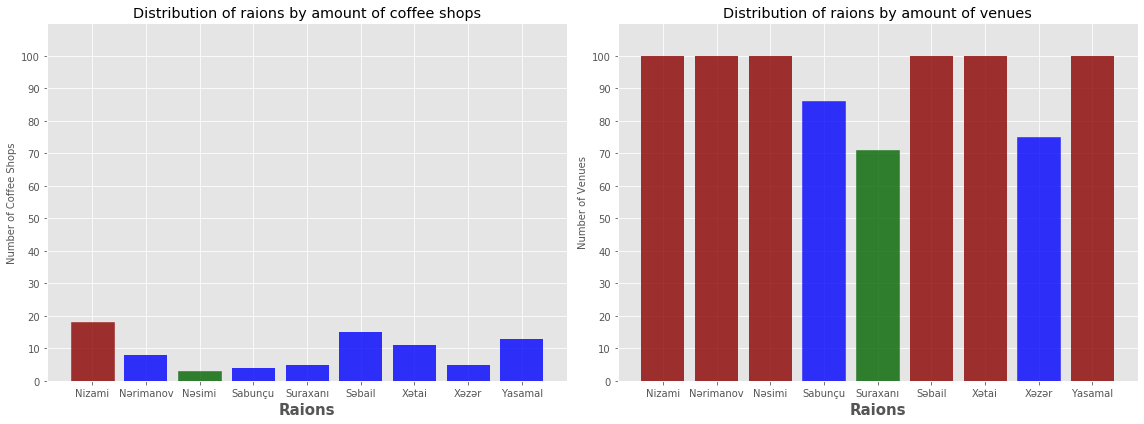

In [326]:
#We can now plot this data side by side to visualize the counts
plt.style.use('ggplot')
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
x1 = coffee_count['Hood']
y1 = coffee_count['Venue']
ax1 = plt.bar(x1, y1, color='blue', alpha=0.8)
ax1[0].set_color('darkred')
ax1[2].set_color('darkgreen')
plt.ylim(1,110)
plt.yticks(np.arange(0, 110, step=10))
plt.xlabel('Raions', fontsize = 15, weight = 'bold')
plt.ylabel('Number of Coffee Shops', fontsize = 10)
plt.title('Distribution of raions by amount of coffee shops')

plt.subplot(1, 2, 2)
x2 = raion_ven_count['Hood']
y2 = raion_ven_count['Venue']
ax2 = plt.bar(x2, y2, color='darkred', alpha=0.8)
ax2[3].set_color('blue')
ax2[7].set_color('blue')
ax2[4].set_color('darkgreen')
plt.ylim(1,110)
plt.yticks(np.arange(0, 110, step=10))
plt.xlabel('Raions', fontsize = 15, weight = 'bold')
plt.ylabel('Number of Venues', fontsize = 10)
plt.title('Distribution of raions by amount of venues')

plt.tight_layout()

plt.show()

The graphics above show us following:

1) The suburb with the most coffee shops while also being densly populated by other type of venues is <b>Nizami</b><br>
2) The densly populated raion with the least amount of coffee shops is <b>Nasimi</b>

This means that if we wish to place our new place in a popular place, but without much contention - <b>Nasimi</b> should be our main choice. If, however, we subscribe to the following line of thinking - so many coffee shop owners can't be wrong - then <b>Nizami</b> is the way to go: not only it is highly populated, but also is the home for most coffee places in Baku. 

In [332]:
#Now let's visualize these two raions and the belonging venues.

all_ven_nizami = baku_venues[baku_venues['Hood'] == 'Nizami'][['Venue','Venue Latitude','Venue Longitude','Venue Category']].reset_index(drop=True)

all_ven_nasimi = baku_venues[baku_venues['Hood'] == 'Nəsimi'][['Venue','Venue Latitude','Venue Longitude','Venue Category']].reset_index(drop=True)

all_ven_nizami.head()


,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Winter Park Hotel,40.375625,49.837330,Hotel
1,Shirvansah Restoran Muzey,40.379582,49.833735,Middle Eastern Restaurant
2,Tarqovaya,40.371961,49.838143,Plaza
3,Zabitlər Parkı,40.385210,49.836205,Park
4,Fəvvarələr Meydanı | Fountains Square (Fəvvarə...,40.371453,49.838396,Plaza


## The Final map

Now that we have acquired and analyzed all the data we had, let's visualize the results on map.

We will only use venues from two raions of interest - Nizami and Nasimi. Each coffee shop within these two raions will have a red circle for Nizami and yellow circle for Nasimi. Blue and yellow smaller circles will represent venues of other categories.

This map will help selecting appropriate streets and neighborhoods for further examinations by stakeholders on their own.

In [347]:
#Defining what the area will be and where Baku is
address = 'Fəvvarələr meydanı, Baku, Azerbaijan'

geolocator = geopy.Nominatim(user_agent="qaqulik")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Baku are {}, {}.'.format(latitude, longitude))


# create map of Baku using latitude and longitude values
baku_coffee_map = folium.Map(location=[latitude, longitude], zoom_start=15)

#add markers to map
#each marker represents neighborhood of Baku

for lat, lng, ven, cat in zip(all_ven_nizami['Venue Latitude'], all_ven_nizami['Venue Longitude'], all_ven_nizami['Venue'],all_ven_nizami['Venue Category']):
    if cat in ['Café', 'Coffee Shop']:
        label = '{}'.format(ven)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='black',
            fill_opacity=0.7,
            parse_html=False).add_to(baku_coffee_map)  
    else:
        label = '{}'.format(ven)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(baku_coffee_map) 

for lat, lng, ven, cat in zip(all_ven_nasimi['Venue Latitude'], all_ven_nasimi['Venue Longitude'], all_ven_nasimi['Venue'],all_ven_nizami['Venue Category']):
    if cat in ['Café', 'Coffee Shop']:
        label = '{}'.format(ven)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='yellow',
            fill=True,
            fill_color='black',
            fill_opacity=0.7,
            parse_html=False).add_to(baku_coffee_map)  
    else:
        label = '{}'.format(ven)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(baku_coffee_map)         
        
baku_coffee_map        

## Results and discussion <a name="results"></a>
    
Our analysis showed that Baku remains a relatively hidden to modern technologies city. While we have managed to find through out data exploration a significant amount of venues in each raion - enough to make some conclussions, it still capped out at 100 venues per raion. That is extremely low for such a densly populated city. That means that Foursquare is not reliable source of data for such analysis in Baku. For the lack of alternative solutions, let's just assume that this is the honest truth.

Then, getting back to our initial statement, there are two ways to approach location selection:
    1) Try the highest place of contention in hopes that success of your competitors means that there will be enough business for everyone
    2) Try your luck at picking dense enough cluster without competition at all in hopes that there are none just because no one else thought about it before
    
For the first option there is only one suggestion to be made - and this the one fairly obvious just by looking at the concetration of markers. It is also obvious location to anyone who has ever visited (or, better yet, lived) in Baku - that is the tourist city center. This is Nizami raion

For the second one there are a few clusters to be considered, each easily seen on the map, belonging to Nasimi raion. It is hard to specify anything with more precision without actually scouting the location on foot.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to help a group of friends to make an informed decision on where to open their new coffee shop. Since there were no concencus on how to approach such a selection, this project tried to accomodate two of their main tactics and provide them with enough data and easy to understand information to make such decision.

Final decission on optimal coffee shop location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc. It is not possible to know all the variables without manually scounting each location.